# Plataforma BNB Linked Data

La [plataforma BNB Linked Data](https://bnb.data.bl.uk/) proporciona acceso a la [British National Bibliography (BNB)](http://www.bl.uk/bibliographic/natbib.html) a través de un punto de acceso SPARQL. 

Este notebook muestra cómo obtener obras relacionadas con un autor, así como también, los lugares de publicación (campos blt:publication y blt:projectedPublication) para crear un mapa interactivo. 

## Configuración global

Damos valor al recurso de autoridad con el que trabajaremos para crear el mapa interactivo.

In [5]:
#bnbIdAutor = 'http://bnb.data.bl.uk/id/person/DickensCharles1812-1870'
#bnbIdAutor = 'http://bnb.data.bl.uk/id/person/BlakeWilliam1757-1827'
#bnbIdAutor = 'http://bnb.data.bl.uk/id/person/WoolfVirginia1882-1941'
bnbIdAutor = 'http://bnb.data.bl.uk/id/person/ShakespeareWilliam1564-1616'

## Importamos las librerías de software

In [6]:
import folium
import requests
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize  

## Obtenemos las obras relacionadas con el autor William Shakespeare

In [17]:
url = 'https://bnb.data.bl.uk/sparql'
sentencia = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
PREFIX bio: <http://purl.org/vocab/bio/0.1/>
PREFIX blt: <http://www.bl.uk/schemas/bibliographic/blterms#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX event: <http://purl.org/NET/c4dm/event.owl#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX isbd: <http://iflastandards.info/ns/isbd/elements/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdau: <http://rdaregistry.info/Elements/u/>
PREFIX madsrdf: <http://www.loc.gov/mads/rdf/v1#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX umbel: <http://umbel.org/umbel#>
PREFIX schema: <http://schema.org/>
PREFIX c4dm: <http://purl.org/NET/c4dm/event.owl#>

SELECT DISTINCT ?recurso ?titulo ?fecha ?lugar WHERE {{
    graph <http://bnb.data.bl.uk/id/graph/BNBCIP> {{
      ?recurso ?p <{0}> ;
         dct:title ?titulo ;
         schema:datePublished ?fecha .
      OPTIONAL {{
          ?recurso blt:projectedPublication ?publicacion .
          ?publicacion c4dm:place ?lugar .
          FILTER regex(?lugar, "geonames", "i")        
      }}
      OPTIONAL {{
          ?recurso blt:publication ?publicacion .
          ?publicacion c4dm:place ?lugar .
          FILTER regex(?lugar, "geonames", "i")        
      }}
    }}
}} LIMIT 500
"""

sentencia = sentencia.format(bnbIdAuthor)

# usamos json como resultado
cabeceras = {'Accept': 'application/sparql-results+json'}
r = requests.get(url, params = {'format': 'application/sparql-results+json', 'query': sentencia}, headers=cabeceras)

print(r.text)


{ "head": { "link": [], "vars": ["recurso", "titulo", "fecha", "lugar"] },
  "results": { "distinct": false, "ordered": true, "bindings": [
    { "recurso": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/013310275" }	, "titulo": { "type": "literal", "value": "Macbeth : teachit KS3 interactive pack" }	, "fecha": { "type": "literal", "value": "2006-01" }	, "lugar": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},
    { "recurso": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/013310276" }	, "titulo": { "type": "literal", "value": "Much ado about nothing : teachit KS3 interactive pack" }	, "fecha": { "type": "literal", "value": "2006-01" }	, "lugar": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},
    { "recurso": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/013315368" }	, "titulo": { "type": "literal", "value": "Hamlet" }	, "fecha": { "type": "literal", "value": "2006-01" }	, "lugar": { "type": "uri", "value": 

## Guardamos el resultado como un fichero CSV 

In [18]:
bnbdatos = json.loads(r.text)

with open('bnb_registros.csv', 'w', newline='') as fichero:
    csv_salida = csv.writer(fichero, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)    

    csv_salida.writerow(['recurso', 'lugar', 'titulo', 'fecha'])

    for i in bnbdatos['results']['bindings']:
        recurso = lugar = titulo = fecha =''

        recurso = i['recurso']['value']
        #if "lugar" in i:
        lugar = i['lugar']['value']
        titulo = i['titulo']['value']
        fecha = i['fecha']['value']

        csv_salida.writerow([recurso,lugar,titulo,fecha])

## Explorando los datos

In [19]:
df = pd.read_csv('bnb_registros.csv')

In [20]:
df

,recurso,lugar,titulo,fecha
0,http://bnb.data.bl.uk/id/resource/013310275,http://sws.geonames.org/6269131/,Macbeth : teachit KS3 interactive pack,2006-01
1,http://bnb.data.bl.uk/id/resource/013310276,http://sws.geonames.org/6269131/,Much ado about nothing : teachit KS3 interacti...,2006-01
2,http://bnb.data.bl.uk/id/resource/013315368,http://sws.geonames.org/6269131/,Hamlet,2006-01
3,http://bnb.data.bl.uk/id/resource/019599478,http://sws.geonames.org/6269131/,Twelfth night : the Alexander text,2020-01
4,http://bnb.data.bl.uk/id/resource/019599479,http://sws.geonames.org/6269131/,The tempest : the alexander text,2019-11
...,...,...,...,...
187,http://bnb.data.bl.uk/id/resource/019806996,http://sws.geonames.org/6252001/,Othello,2020-05
188,http://bnb.data.bl.uk/id/resource/020080122,http://sws.geonames.org/6269131/,The tragicomedies,2021-01
189,http://bnb.data.bl.uk/id/resource/020103067,http://sws.geonames.org/6269131/,As you like it,2021-04
190,http://bnb.data.bl.uk/id/resource/020109015,http://sws.geonames.org/6269131/,All the sonnets of Shakespeare,2021-02


## ¿Cuántos registros hemos recuperado?

In [21]:
len(df)

192

### Vamos a contar el número de resultados por lugar

In [22]:
lugares_por_recurso = df.groupby("lugar")["recurso"].count()

In [23]:
lugares_por_recurso

lugar
http://sws.geonames.org/1269750/      2
http://sws.geonames.org/2635167/      1
http://sws.geonames.org/2921044/      9
http://sws.geonames.org/6251999/      3
http://sws.geonames.org/6252001/     75
http://sws.geonames.org/6269131/    102
Name: recurso, dtype: int64

### Creamos una gráfica para visualizar los recursos por fecha

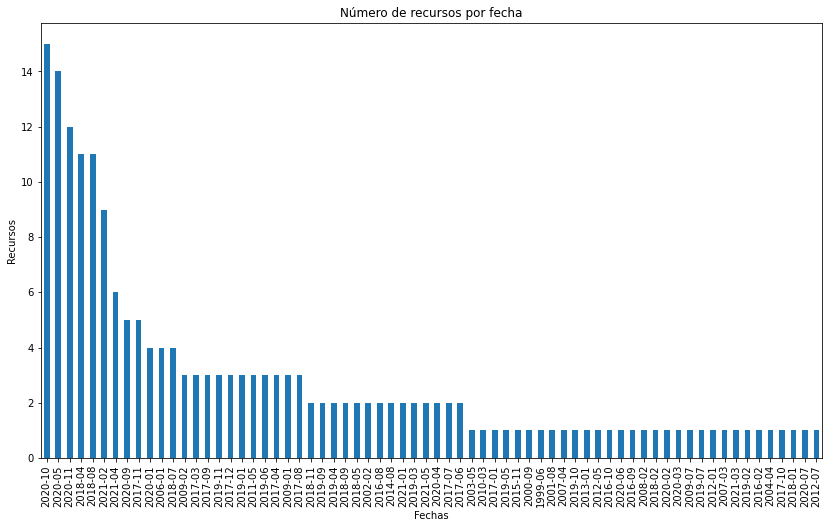

In [24]:
ax = df['fecha'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Número de recursos por fecha")
ax.set_xlabel("Fechas")
ax.set_ylabel("Recursos")
plt.show()

### Agrupamos los elementos por año

In [25]:
df['año'] = pd.DatetimeIndex(df['fecha']).year

In [26]:
df['año']

0      2006
1      2006
2      2006
3      2020
4      2019
       ... 
187    2020
188    2021
189    2021
190    2021
191    2021
Name: año, Length: 192, dtype: int64

### Creamos una gráfica por año

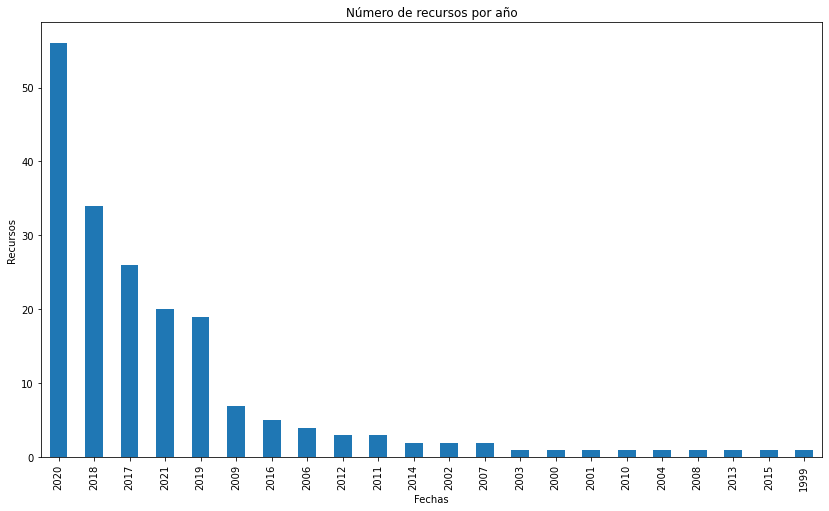

In [27]:
ax = df['año'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Número de recursos por año")
ax.set_xlabel("Fechas")
ax.set_ylabel("Recursos")
plt.show()

## Explorando los lugares

In [29]:
lugares = pd.unique(df['lugar']).tolist()
cadena_lugares = ''
for a in sorted(lugares):
    print(a)
    cadena_lugares = cadena_lugares + ' \"' + a.replace("http://sws.geonames.org/", "").replace("/", "") + '\"'

http://sws.geonames.org/1269750/
http://sws.geonames.org/2635167/
http://sws.geonames.org/2921044/
http://sws.geonames.org/6251999/
http://sws.geonames.org/6252001/
http://sws.geonames.org/6269131/


### Obtenemos la latitud y la longitud de Wikidata

In [30]:
url = 'https://query.wikidata.org/sparql'
sentencia = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE {{ 
  values ?idgeonames {{ {0} }} 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
}}
"""

sentencia = sentencia.format(cadena_lugares)
print(sentencia)

r = requests.get(url, params = {'format': 'json', 'query': sentencia})
puntos_geo = r.json()


PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE { 
  values ?idgeonames {  "1269750" "2635167" "2921044" "6251999" "6252001" "6269131" } 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}



### Finalmente, añadimos los marcadores al mapa

In [33]:
mapa = folium.Map(location=[0,0], zoom_start=1.5)

for geo in puntos_geo['results']['bindings']:
    idwikidata = geo['x']['value']
    lat = geo['lat']['value']
    lon = geo['lon']['value']
    idgeonames = geo['idgeonames']['value']
    etiqueta = geo['xLabel']['value']
    print(lat, lon)
    
    # adding a text to the popup
    count = lugares_por_recurso[['http://sws.geonames.org/' + idgeonames + '/']][0]
    texto_popup = str(count) + " registros publicados en <a hreh='" + str(idwikidata) + "'>" + etiqueta + "</a>"
    
    folium.Marker([lat,lon], popup= texto_popup).add_to(mapa)

51.0 10.0
39.828175 -98.5795
22.8 83.0
54.6 -2.0
53.0 -1.0
56.0 -109.0


In [34]:
mapa